# Processamento dos dados de Salinopolis

In [1]:
import conda

import os
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap as bm

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
import geopy.distance

In [2]:
def read_pnboia(pathname, filename):
    """
    Leitura dos parametros do PNBOIA
    """
    df1 = pd.read_csv(pathname + filename, parse_dates=True, index_col='Datetime')

    # serie de dados continua
    df = df1['2017-01-01':'2017-11-30']
    return df

In [3]:
def uv2id(u, v):
    """
    Conversao de u e v para intensidade e direcao
    """
    i = np.sqrt(u ** 2 + v ** 2)
    d = (np.rad2deg(np.arctan2(u, v))) % 360.
    return i, d

In [4]:
def read_etopo(pathname, filename):
    """
    Leitura dos dados de batimetria do ETOPO
    """
    etopo = xr.open_dataset(pathname + filename)
    etopo1 = etopo.sel(lon=slice(-52,-32), lat=slice(-10,5))
    return etopo1

In [5]:
def read_era5_param(pathname, filename, datei, datef, ponto):
    """
    Leitura dos parâmetros do ERA5
    - pathname - path do arquivo netcdf
    - filename - arquivo netcdf
    - ponto mais proximo para pegar no era5
    - datei - data inicial
    - dataf - data final
    """
    ds = xr.open_dataset(pathname + filename)
    
    # seleciona ponto mais proximo
    ds1 = ds.sel(longitude=ponto[1], latitude=ponto[0], method='nearest')
    ds2 = ds1.sel(time=slice(datei, datef))
    df = ds2.to_dataframe()
    df['ws'], df['wd'] = uv2id(df.u10, df.v10)
    
    df.index.name = 'date'
    return ds, df

In [6]:
def plot_bmop_loc(etopo1, df_sal, df_for, boia):
    """
    """
    # lat lon ERA5
    lat_sal = df_sal.latitude[0]
    lon_sal = df_sal.longitude[0]
    lat_for = df_for.latitude[0]
    lon_for = df_for.longitude[0]
    lat_boia = boia.Lat[0]
    lon_boia = boia.Lon[0]

#     radius_era5_km = 0.3
#     radius_era5 = 1.0 * radius_era5_km / 111.0 #km to degrees


    # cria matriz com lat lon
    lons, lats = np.meshgrid(etopo1.lon.data, etopo1.lat.data)

    # m = bm(projection='cyl',llcrnrlat=lat_fso-.03,urcrnrlat=lat_fso+.03,
    #          llcrnrlon=lon_fso-.04,urcrnrlon=lon_fso+.04, lat_ts=0,resolution='l')

    m = bm(projection='cyl',llcrnrlat=-10,urcrnrlat=5, 
           llcrnrlon=-52,urcrnrlon=-32, lat_ts=0,resolution='h')

    fig = plt.figure(figsize=(8,8))
    # lvls = np.arange(-4000,0,1)
    lvls = [-4000, -2000, -1000, -500, -200, -25]
    CS1 = m.contour(lons, lats, etopo1.z, colors='black',
    #                 cmap=plt.cm.jet,
                    levels=lvls, alpha=0.3)
    plt.clabel(CS1, inline=1, inline_spacing=3, fontsize=10, fmt='%i')#, manual=manual_locations)
    
    plt.xticks(rotation=15)

    m.drawcoastlines()
    m.drawstates()
    m.fillcontinents()
    m.drawmeridians(np.arange(-52, -32, 2), labels=[0,0,0,1], linewidth=0.3)
    m.drawparallels(np.arange(-10, 5, 2), labels=[1,0,0,0], linewidth=0.3)
    
    xx, yy = np.meshgrid(ds_sal.longitude.values, ds_sal.latitude.values)
    plt.plot(xx, yy, 'ko', markersize=5)
    xx, yy = np.meshgrid(ds_for.longitude.values, ds_for.latitude.values)
    plt.plot(xx, yy, 'ko', markersize=5)

    # plota posicoes e nomes
    m.plot(lon_sal, lat_sal, 'k.', markersize=7)
    plt.text(lon_sal+0.02, lat_sal+0.01, 'ERA5_Sal', color='r', fontweight='bold', fontsize=14)
    m.plot(lon_for, lat_for, 'k.', markersize=7)
    plt.text(lon_for+0.02, lat_for+0.01, 'ERA5_For', color='r', fontweight='bold', fontsize=14)
    m.plot(lon_boia, lat_boia, 'g.', markersize=7)
    plt.text(lon_boia+0.02, lat_boia-0.05, 'Boia', color='r', fontweight='bold', fontsize=14)
    # m.tissot(lon_era5, lat_era5, radius_era5, 30, color='k', alpha=0.2)

#     m.plot(lon_buoy, lat_buoy, 'k.', markersize=7)
    # m.tissot(lon_buoy, lat_buoy, radius_buoy, 30, color='k', alpha=0.2)
#     plt.text(lon_buoy+0.02, lat_buoy+0.01, 'BMOP', color='r', fontweight='bold', fontsize=14)

    plt.xticks(rotation=15)
    return fig

In [7]:
path_era5 = os.environ['HOME'] + '/Documents/salinopolis/dados/era5/'
path_pnboia = os.environ['HOME'] + '/Documents/salinopolis/dados/pnboia/'
path_etopo = os.environ['HOME']+ '/Documents/dados/etopo/'

datei = '2016-01-01 00:00:00'
datef = '2017-12-31 23:00:00'

# leitura dos dados do pnboia
boia = read_pnboia(path_pnboia, 'pnboia_fortaleza.csv')

# leitura dos dados do era5
ds_sal, df_sal = read_era5_param(path_era5, 'ERA5_param_salinopolis.nc', datei, datef, ponto=[0, -47])
ds_for, df_for = read_era5_param(path_era5, 'ERA5_param_fortaleza.nc', datei, datef, ponto=[-3.2138, -38.4325])

# leitura dos dados de batimetria do ETOPO
etopo1 = read_etopo(path_etopo, 'ETOPO-REMO.nc')

/usr/local/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/usr/local/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


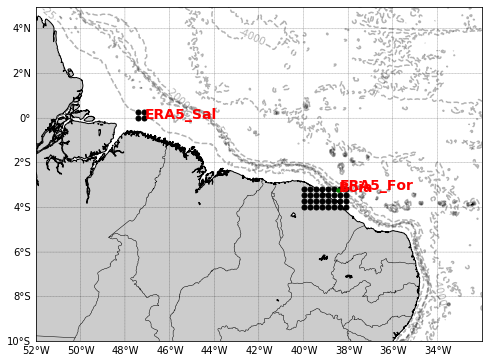

In [8]:
# plota localizacao do ERA5 e Boia

%matplotlib inline

fig = plot_bmop_loc(etopo1, df_sal, df_for, boia)

# plt.savefig(path + 'localizacao_era5_salinopolis.png', bbox_inches="tight")

In [9]:
# calcula distancia entre 2 coordenadas

print ('Distância entre Boia e ERA5_For: {:.1f} km'.format(
       geopy.distance.geodesic((boia.Lon[0], boia.Lat[0]), (df_for.longitude[0], df_for.latitude[0])).km))

print ('Distância entre Boia e ERA5_Sal: {:.1f} km'.format(
       geopy.distance.geodesic((boia.Lon[0], boia.Lat[0]), (df_sal.longitude[0], df_sal.latitude[0])).km))

print ('Distância entre ERA5_Sal e ERA5_For: {:.1f} km'.format(
       geopy.distance.geodesic((df_sal.longitude[0], df_sal.latitude[0]), (df_for.longitude[0], df_for.latitude[0])).km))

print ('Distância entre pontos de grade do ERA5: {:.2f} km'.format(
       geopy.distance.geodesic((ds_sal.longitude[0], ds_sal.latitude[0]), (ds_sal.longitude[1], ds_sal.latitude[1])).km))

Distância entre Boia e ERA5_For: 6.2 km
Distância entre Boia e ERA5_Sal: 1001.1 km
Distância entre ERA5_Sal e ERA5_For: 1006.3 km
Distância entre pontos de grade do ERA5: 36.31 km


In [14]:
# salva dados do ERA5
df_sal.to_csv(path_era5 + 'era5_param_salinopolis.csv')
df_for.to_csv(path_era5 + 'era5_param_fortaleza.csv')

(412008, 420023)

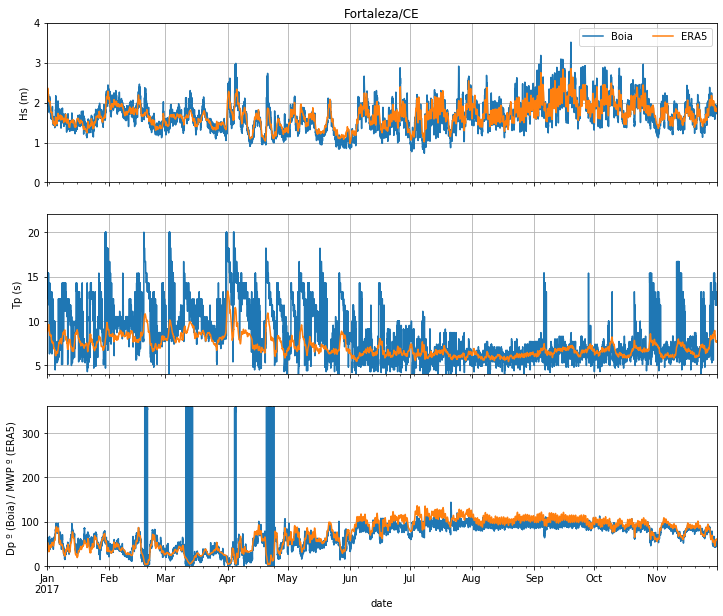

In [11]:
# plotagem dos dados do pnboia e do era5 de fortaleza

%matplotlib inline
fig, axes = plt.subplots(nrows=3,
                         ncols=1,
                         figsize=(12,10),
                         sharex=True)

# ax1 = fig.add_subplot(311)
axes[0].set_title('Fortaleza/CE')
boia.Wvht.plot(ax=axes[0], ylim=(0,4), label='Boia')
df_for.swh.plot(ax=axes[0], label='ERA5')
axes[0].set_ylabel('Hs (m)')
axes[0].legend(ncol=2)
# axes[0].grid('on', which='major')
# axes[0].grid('off', which='major', axis='xy' )
axes[0].grid()
boia.Dpd.plot(ax=axes[1], ylim=(4,22))
df_for.mwp.plot(ax=axes[1])
axes[1].set_ylabel('Tp (s)')
axes[1].grid()
# ax3 = fig.add_subplot(313)
boia.Mwd.plot(ax=axes[2], ylim=(0, 360))
df_for.mwd.plot(ax=axes[2])
axes[2].set_ylabel('Dp º (Boia) / MWP º (ERA5) ')
axes[2].grid()
axes[2].set_xlim(boia.index[0], boia.index[-1])

(412008, 420023)

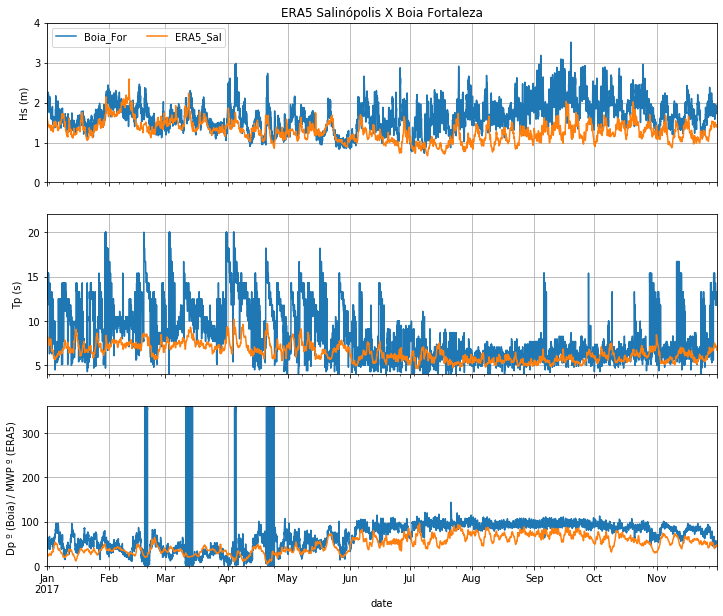

In [12]:
# plotagem dos da boia de fortaleza e era5 de salinopolis


%matplotlib inline
fig, axes = plt.subplots(nrows=3,
                         ncols=1,
                         figsize=(12,10),
                         sharex=True)

# ax1 = fig.add_subplot(311)
axes[0].set_title('ERA5 Salinópolis X Boia Fortaleza')
boia.Wvht.plot(ax=axes[0], ylim=(0,4), label='Boia_For')
df_sal.swh.plot(ax=axes[0], label='ERA5_Sal')
axes[0].set_ylabel('Hs (m)')
axes[0].legend(ncol=2)
# axes[0].grid('on', which='major')
# axes[0].grid('off', which='major', axis='xy' )
axes[0].grid()
boia.Dpd.plot(ax=axes[1], ylim=(4,22))
df_sal.mwp.plot(ax=axes[1])
axes[1].set_ylabel('Tp (s)')
axes[1].grid()
# ax3 = fig.add_subplot(313)
boia.Mwd.plot(ax=axes[2], ylim=(0, 360))
df_sal.mwd.plot(ax=axes[2])
axes[2].set_ylabel('Dp º (Boia) / MWP º (ERA5) ')
axes[2].grid()
axes[2].set_xlim(boia.index[0], boia.index[-1])

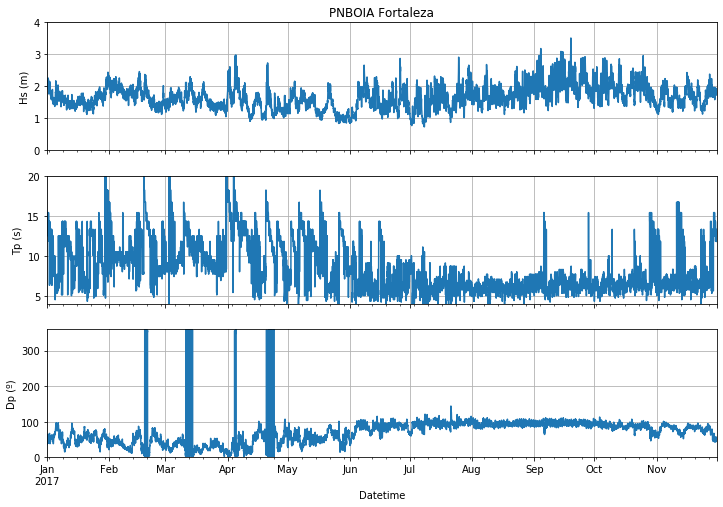

In [13]:
# plotagem dos dados do pnboia


%matplotlib inline
fig, axes = plt.subplots(nrows=3,
                         ncols=1,
                         figsize=(12,8),
                         sharex=True)

# ax1 = fig.add_subplot(311)
axes[0].set_title('PNBOIA Fortaleza')
boia.Wvht.plot(ax=axes[0], ylim=(0,4))
axes[0].set_ylabel('Hs (m)')
# axes[0].grid('on', which='major')
# axes[0].grid('off', which='major', axis='xy' )
axes[0].grid()
boia.Dpd.plot(ax=axes[1], ylim=(4,20))
axes[1].set_ylabel('Tp (s)')
axes[1].grid()
# ax3 = fig.add_subplot(313)
boia.Mwd.plot(ax=axes[2], ylim=(0, 360))
axes[2].set_ylabel('Dp (º)')
axes[2].grid()